Import datasets

In [1]:
import pandas as pd
import numpy as np

EDGE_COLS = [
    'Bwd Packet Length Min', 'Protocol_6', 'Bwd Packets/s', 'FWD Init Win Bytes',
    'Packet Length Std', 'FIN Flag Count', 'SrcPortRange_registered',
    'Packet Length Min', 'Fwd Seg Size Min', 'DstPortRange_well_known',
    'Bwd IAT Total', 'SYN Flag Count', 'Bwd Packet Length Std'
]
LABEL_COL = "target"
ID_COLS = ['Src IP', 'Dst IP', 'Timestamp']

df_train = pd.read_csv("data/train.csv")
df_test = pd.read_csv("data/test.csv")

X_train = df_train.drop(columns=[LABEL_COL, "Src IP", "Dst IP", "Timestamp"])
y_train = df_train[LABEL_COL]
X_test  = df_test.drop(columns=[LABEL_COL, "Src IP", "Dst IP", "Timestamp"])
y_test  = df_test[LABEL_COL]

print(df_train.shape)
print(df_train.columns)
print(df_train.loc[1])

(25901651, 17)
Index(['Timestamp', 'Src IP', 'Dst IP', 'Bwd Packet Length Min', 'Protocol_6',
       'Bwd Packets/s', 'FWD Init Win Bytes', 'Packet Length Std',
       'FIN Flag Count', 'SrcPortRange_registered', 'Packet Length Min',
       'Fwd Seg Size Min', 'DstPortRange_well_known', 'Bwd IAT Total',
       'SYN Flag Count', 'Bwd Packet Length Std', 'target'],
      dtype='object')
Timestamp                  2018-02-16 12:38:45.787171
Src IP                                   172.31.66.26
Dst IP                                  23.219.88.169
Bwd Packet Length Min                               0
Protocol_6                                       True
Bwd Packets/s                                0.133515
FWD Init Win Bytes                               8192
Packet Length Std                          113.214348
FIN Flag Count                                      0
SrcPortRange_registered                         False
Packet Length Min                                   0
Fwd Seg Size Min  

#### Recreate the full dataset

In [2]:
df_all = pd.concat([df_train, df_test], ignore_index=True)
df_all.shape

(32377064, 17)

#### Extract all unique communications

In [3]:
import networkx as nx

# Get unique pairs of communicating IPs
edges = df_all[['Src IP', 'Dst IP']].drop_duplicates()

# Create the binary graph
G = nx.Graph()
G.add_edges_from(edges.itertuples(index=False, name=None))

print(f"Graph built with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")

Graph built with 107583 nodes and 1358779 edges


#### Generate node embeddings

In [4]:
# from node2vec import Node2Vec

# node2vec = Node2Vec(
#     G,
#     dimensions=128,   # embedding dimension
#     walk_length=20,
#     num_walks=100,
#     workers=4
# )
# model = node2vec.fit(window=10, min_count=1, batch_words=4)

# # Save or access embeddings
# embeddings = {node: model.wv[node] for node in G.nodes()}

better perfmormance

In [5]:
# from karateclub.node_embedding.neighbourhood import Node2Vec

# model = Node2Vec(dimensions=128, walk_length=10, num_walks=10, workers=8)
# model.fit(G)
# embeddings = model.get_embedding()

##### Generate node embeddings using torch

In [6]:
# 1. Convert node labels to integers

import networkx as nx
import torch

# Create mapping from node -> integer ID
mapping = {node: i for i, node in enumerate(G.nodes())}

# Relabel graph
G_int = nx.relabel_nodes(G, mapping)

# Convert to edge_index tensor
edge_index = torch.tensor(list(G_int.edges)).t().contiguous().long()

print(edge_index.shape)
print(edge_index[:, :5])  # preview first edges

torch.Size([2, 1358779])
tensor([[0, 0, 0, 0, 0],
        [1, 2, 3, 4, 5]])


In [7]:
# 2. Continue with Node2Vec
from torch_geometric.nn import Node2Vec

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = Node2Vec(
    edge_index,
    embedding_dim=64,          # smaller = faster
    walk_length=10,
    context_size=5,
    walks_per_node=5,
    num_negative_samples=1,
    sparse=True
).to(device)

generate embeddings

In [8]:

# Quick training
# loader = model.loader(batch_size=256, shuffle=True, num_workers=8)
# fix for dataloader bug
loader = model.loader(batch_size=128, shuffle=True, num_workers=0)
optimizer = torch.optim.SparseAdam(list(model.parameters()), lr=0.01)

def train():
    model.train()
    total_loss = 0
    for pos_rw, neg_rw in loader:
        optimizer.zero_grad()
        loss = model.loss(pos_rw.to(device), neg_rw.to(device))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

for epoch in range(3):  # only a few epochs for speed
    loss = train()
    print(f"Epoch {epoch}, loss: {loss:.4f}")

Epoch 0, loss: 3.1682
Epoch 1, loss: 1.9770
Epoch 2, loss: 1.3759


In [9]:
# Extract embeddings
emb = model.embedding.weight.cpu().detach().numpy()

### Map embeddings back to IPs

In [10]:
# Reverse mapping: integer ID -> IP
rev_mapping = {v: k for k, v in mapping.items()}

rand_flow = list(G.edges())[0]
print(rand_flow)
rand_ip = rand_flow[1]

ip_emb = emb[mapping[rand_ip]]
print(ip_emb)

('172.31.66.26', '72.21.91.29')
[-0.3424941   0.6024212  -0.373335    0.803157    0.66213787  0.17053209
  0.91278344 -0.28766263 -0.6697911  -0.7850958  -0.01198456 -0.5174365
 -0.82712203  0.3335587  -0.5067515  -0.6426475  -0.4393154   0.03705976
  0.40874833 -0.20431788 -0.6456775  -1.0613002   0.5997615  -0.25982964
  0.2850039   0.03207998 -0.4121838   0.67326313 -0.55572164 -0.0327014
  0.83179826 -0.00796694  0.8677467   0.33668372  0.46210933  0.8154876
  0.6478519   1.1182681   1.3270934  -0.03136138 -0.5396446  -0.13161035
  0.38652748 -0.08819209  0.47637263  0.52090013 -0.94868594  0.80731213
 -0.56697303 -0.45738283  0.16072176 -0.02509824 -0.00513888 -0.1959731
  0.42657536  0.97810036  0.28028896  0.5773665  -0.1611644  -0.6103475
 -0.74033785 -1.0803043  -0.7530162   0.43946412]


In [ ]:
node_ids = list(mapping.keys())  # original IPs
embedding_df = pd.DataFrame(emb, index=node_ids)

def add_node2vec_features(df, embedding_df, is_test=False):
    # Merge source and destination embeddings
    src_emb = embedding_df.loc[df['Src IP']].reset_index(drop=True)
    # if is_test:
    #     print("individual:", src_emb[6])
    dst_emb = embedding_df.loc[df['Dst IP']].reset_index(drop=True)
    
    # Rename columns
    src_emb.columns = [f'src_emb_{i}' for i in range(src_emb.shape[1])]
    dst_emb.columns = [f'dst_emb_{i}' for i in range(dst_emb.shape[1])]
    
    # Concatenate with original features
    df_with_emb = pd.concat([df.reset_index(drop=True), src_emb, dst_emb], axis=1)
    return df_with_emb

train_with_emb = add_node2vec_features(df_train, embedding_df)
test_with_emb  = add_node2vec_features(df_test, embedding_df, is_test=True)

individual: 0          0.407559
1          0.407559
2          0.407559
3          0.407559
4          0.407559
             ...   
6475408   -0.224139
6475409   -0.558488
6475410    0.302759
6475411    0.519446
6475412    0.322564
Name: 6, Length: 6475413, dtype: float32


In [28]:
embedding_df.to_parquet("data/node2vec_embeddings.parquet")

In [12]:
# Now X_train includes edge features + src/dst embeddings
X_train = train_with_emb.drop(columns=['target', 'Src IP', 'Dst IP', 'Timestamp'])
y_train = train_with_emb['target']

X_test = test_with_emb.drop(columns=['target', 'Src IP', 'Dst IP', 'Timestamp'])
y_test = test_with_emb['target']

In [ ]:
# Sanity check
print(X_test.loc[1]['src_emb_1'] == X_train.loc[1]['src_emb_1'])

False


In [ ]:
# print(embedding_df.loc[df_test.loc[1]['Src IP']][54:56])
# embedding_df.loc[df['Src IP']]

54    0.022631
55    0.196847
Name: 172.31.64.81, dtype: float32


In [ ]:
# rand_flow = df_all.loc[6]
# print(rand_flow)
# rand_ip = rand_flow['Src IP']

# ip_emb = emb[mapping[rand_ip]]
# print(ip_emb[54:56])

Timestamp                  2018-02-16 12:41:36.695137
Src IP                                   172.31.66.26
Dst IP                                 52.168.138.145
Bwd Packet Length Min                              48
Protocol_6                                      False
Bwd Packets/s                                0.031234
FWD Init Win Bytes                                  0
Packet Length Std                                 0.0
FIN Flag Count                                      0
SrcPortRange_registered                         False
Packet Length Min                                  48
Fwd Seg Size Min                                    8
DstPortRange_well_known                          True
Bwd IAT Total                                64014359
SYN Flag Count                                      0
Bwd Packet Length Std                             0.0
target                                              0
Name: 6, dtype: object
[-0.74433124  0.7410814 ]


In [ ]:
# print(train_with_emb.loc[0])
# # print(X_train_full.loc[123_456])

Timestamp                2018-02-16 12:38:47.587883
Src IP                                 172.31.66.26
Dst IP                                  72.21.91.29
Bwd Packet Length Min                             0
Protocol_6                                     True
                                    ...            
dst_emb_59                                 -0.07348
dst_emb_60                                 0.111197
dst_emb_61                                 0.254103
dst_emb_62                                 0.086736
dst_emb_63                                  0.41298
Name: 0, Length: 145, dtype: object


In [13]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score

In [14]:
print(df_train.shape)
print(df_train.columns)
print(df_train.loc[1])

print("Training distribution:")
print(y_train.value_counts())
print(f"Training malicious ratio: {y_train.value_counts()[1] / len(y_train):.6f}")

print("\nTest distribution:")
print(y_test.value_counts())
print(f"Test malicious ratio: {y_test.value_counts()[1] / len(y_test):.6f}")

(25901651, 17)
Index(['Timestamp', 'Src IP', 'Dst IP', 'Bwd Packet Length Min', 'Protocol_6',
       'Bwd Packets/s', 'FWD Init Win Bytes', 'Packet Length Std',
       'FIN Flag Count', 'SrcPortRange_registered', 'Packet Length Min',
       'Fwd Seg Size Min', 'DstPortRange_well_known', 'Bwd IAT Total',
       'SYN Flag Count', 'Bwd Packet Length Std', 'target'],
      dtype='object')
Timestamp                  2018-02-16 12:38:45.787171
Src IP                                   172.31.66.26
Dst IP                                  23.219.88.169
Bwd Packet Length Min                               0
Protocol_6                                       True
Bwd Packets/s                                0.133515
FWD Init Win Bytes                               8192
Packet Length Std                          113.214348
FIN Flag Count                                      0
SrcPortRange_registered                         False
Packet Length Min                                   0
Fwd Seg Size Min  

In [15]:
scale = y_train.value_counts()[0] / y_train.value_counts()[1]
model = XGBClassifier(
    learning_rate=0.1,
    n_estimators=1_000,
    max_depth=5,
    min_child_weight=1,
    gamma=1,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0,
    scale_pos_weight=scale,
    # max_delta_step=1,
    eval_metric="auc",
    tree_method="hist",
    random_state=42
)

model.fit(X_train, y_train)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'auc'


In [16]:
# Lower the classification threshold

from sklearn.metrics import precision_recall_curve

y_proba = model.predict_proba(X_test)[:, 1]
prec, rec, thr = precision_recall_curve(y_test, y_proba)

# pick threshold that maximizes F1
import numpy as np
f1 = 2*prec*rec/(prec+rec+1e-8)
best_thr = thr[np.argmax(f1)]
print("Best threshold:", best_thr)

y_pred = (y_proba >= best_thr).astype(int)

Best threshold: 1.1812063e-05


In [17]:
from sklearn.metrics import average_precision_score
print("PR-AUC:", average_precision_score(y_test, y_proba))

PR-AUC: 0.999544437890233


In [18]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
print(cm)

[[5390635     584]
 [    194 1084000]]


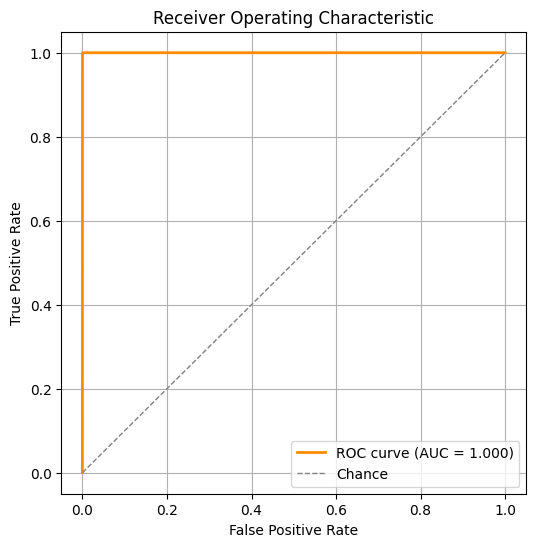

In [19]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label=f"ROC curve (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', label='Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

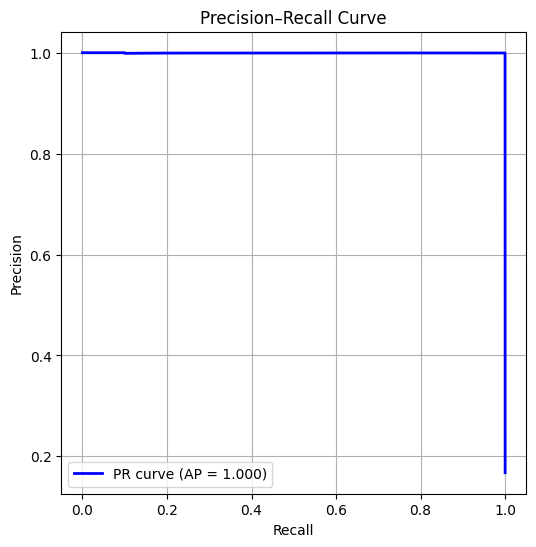

In [20]:
from sklearn.metrics import precision_recall_curve, average_precision_score

prec, rec, thr = precision_recall_curve(y_test, y_proba)
ap = average_precision_score(y_test, y_proba)

plt.figure(figsize=(6, 6))
plt.plot(rec, prec, color='blue', lw=2, label=f'PR curve (AP = {ap:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision–Recall Curve')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()

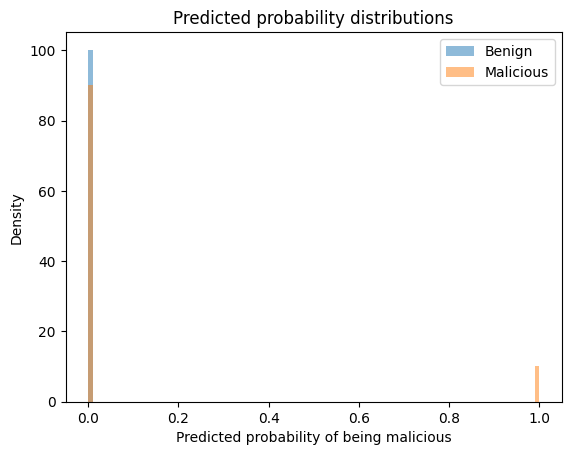

In [21]:
import matplotlib.pyplot as plt

y_proba = model.predict_proba(X_test)[:,1]
plt.hist(y_proba[y_test==0], bins=100, alpha=0.5, label="Benign", density=True)
plt.hist(y_proba[y_test==1], bins=100, alpha=0.5, label="Malicious", density=True)
plt.legend()
plt.xlabel("Predicted probability of being malicious")
plt.ylabel("Density")
plt.title("Predicted probability distributions")
plt.show()

In [22]:
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score

y_proba = model.predict_proba(X_test)[:,1]
print("ROC-AUC:", roc_auc_score(y_test, y_proba))
print("AUPRC:", average_precision_score(y_test, y_proba))

print("Malicious/Benign ratio:", y_train.value_counts()[0] / y_train.value_counts()[1])
print(y_train.value_counts())

ROC-AUC: 0.9999506834362067
AUPRC: 0.999544437890233
Malicious/Benign ratio: 9.415948253328668
target
0    23414921
1     2486730
Name: count, dtype: int64


In [ ]:
model.save_model("models/xgboost_node2vec.json")
# To reload later
# from xgboost import XGBClassifier
# model = XGBClassifier()
# model.load_model("models/xgboost_node2vec.json")